In [2]:
import time
from tqdm import tqdm
import os
import cv2
import numpy as np

from ultralytics import YOLO

import supervision as sv

import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
model = YOLO('../runs/detect/train3/weights/best.pt')

In [118]:
VIDEO_PATH = r'../video/video_03.mp4'

In [119]:
# 获取视频信息
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

In [120]:
video_info.resolution_wh

(1280, 720)

In [127]:
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
for _ in range(360):
    frame = next(iterator)

In [128]:
frame.shape

(720, 1280, 3)

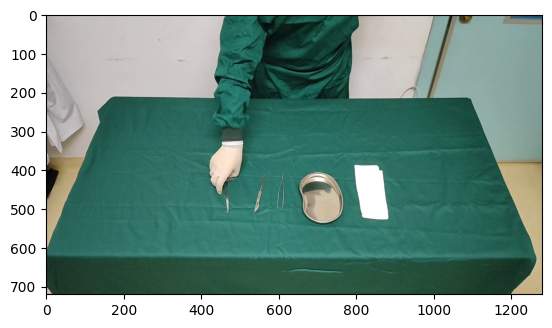

In [129]:
plt.imshow(frame[:,:,::-1])
plt.show()

In [130]:
zone = np.array([[175, 210], [1090, 215], [1265, 620], [0, 615]])

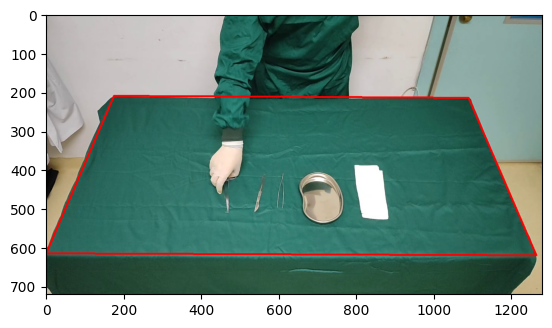

In [131]:
t = frame.copy()
t = cv2.polylines(t, np.int32([zone]), True, (0, 0, 255), 3)
plt.imshow(t[:, :, ::-1])
plt.show()

In [134]:
def deal(frame: np.ndarray, i) -> np.ndarray:
    t = frame
    dst = np.int32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(np.float32([zone]), np.float32([dst]))
    t = cv2.warpPerspective(t, M, [1280, 720])
    return t
# plt.imshow(t[:384, :700, ::-1])
# plt.show()
sv.process_video(VIDEO_PATH, 'temp.mp4', deal)

---

In [61]:
model = YOLO(r'../runs/detect/train3/weights/best.pt')
# VIDEO_PATH = r'../video/video_01.mp4'
VIDEO_PATH = r'../video/video_01.mp4'

In [62]:
generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

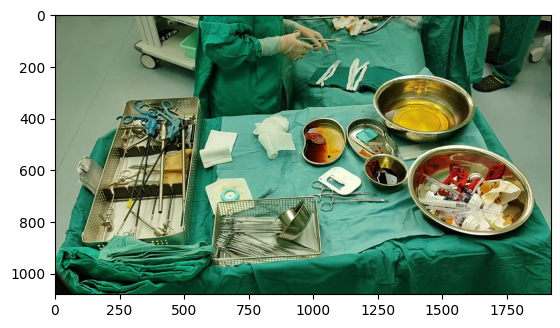

In [63]:
plt.imshow(frame[:,:,::-1])
plt.show()

In [64]:
zone = np.array([[200, 420], [1600, 330], [1920, 850], [5, 1030]])

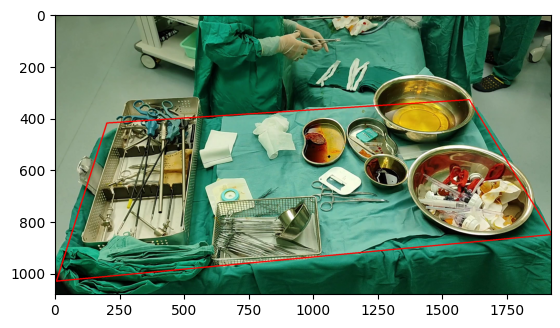

In [65]:
t = frame.copy()
t = cv2.polylines(t, np.int32([zone]), True, (0, 0, 255), 3)
plt.imshow(t[:, :, ::-1])
plt.show()

2


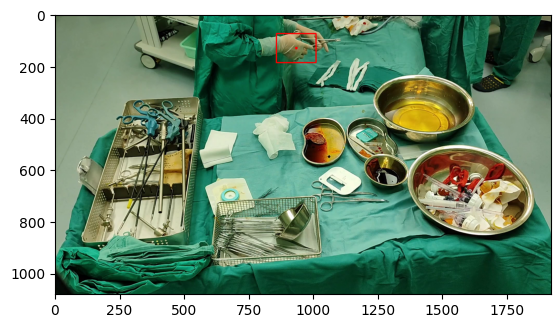

In [38]:
ret = model(frame, imgsz=1280, verbose=False, show=False, device='cuda')[0]
print(len(ret.boxes.data))

p1 = [int(i) for i in ret.boxes.xyxy[0, :2].tolist()]
p2 = [int(i) for i in ret.boxes.xyxy[0, 2:].tolist()]

cv2.rectangle(frame, p1, p2, (0, 0, 255), 3)

cv2.circle(frame, (int(ret.boxes.xywh[0, 0]), int(ret.boxes.xywh[0, 1])), 5,  (0, 0, 255), -1)

plt.imshow(frame[:, :, ::-1])
plt.show()

In [39]:
cv2.pointPolygonTest(zone, (int(ret.boxes.xywh[0, 0]), int(ret.boxes.xywh[0, 1])), False )

-1.0

In [40]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    ret = model(frame, imgsz=1280, verbose=False, show=False, device='cuda:0')[0]
    if len(ret.boxes.data) == 0:
        pbar.update(1)
        return frame
    sign = cv2.pointPolygonTest(zone, (int(ret.boxes.xywh[0, 0]), int(ret.boxes.xywh[0, 1])), False)
    if  sign== 1:
        text = 'in'
    elif sign == 0:
        text = 'edge'
    else:
        text = 'out'

    
    cv2.putText(frame, text, (200, 100), cv2.FONT_HERSHEY_COMPLEX, 2.0, (100, 200, 200), 5)
    pbar.update(1)
    return frame

In [54]:
def process_frame2(frame: np.ndarray, i) -> np.ndarray:
    ret = model(frame, imgsz=1280, verbose=False, show=False, device='cuda:0', conf=0.5)[0]
    for idx in range(len(ret.boxes.data)):
        if ret.boxes.cls[idx] == 0:
            color = (0, 0, 255)
        else:
            color = (255, 0, 0)
        p1 = [int(i) for i in ret.boxes.xyxy[idx, :2].tolist()]
        p2 = [int(i) for i in ret.boxes.xyxy[idx, 2:].tolist()]
        cv2.rectangle(frame, p1, p2, color, 4)
    pbar.update(1)
    return frame

In [47]:
def process_frame3(frame: np.ndarray, i) -> np.ndarray:
    ret = model(frame, imgsz=1280, verbose=False, show=False, device='cuda:0', conf=0.5)[0]
    if len(ret.boxes.data) == 0:
        pbar.update(1)
        return frame
    for idx in range(len(ret.boxes.data)):
        sign = cv2.pointPolygonTest(zone, (int(ret.boxes.xywh[idx, 0]), int(ret.boxes.xywh[idx, 1])), False)
        if sign == 1:
            if ret.boxes.cls[idx] == 0:
                color = (0, 0, 255)
            else:
                color = (255, 0, 0)
            p1 = [int(i) for i in ret.boxes.xyxy[idx, :2].tolist()]
            p2 = [int(i) for i in ret.boxes.xyxy[idx, 2:].tolist()]
            cv2.rectangle(frame, p1, p2, color, 4)

            cv2.circle(frame, (int(ret.boxes.xywh[idx, 0]), int(ret.boxes.xywh[idx, 1])), 5,  color, -1)
    pbar.update(1)
    return frame

In [51]:
OUT_PATH = 'ret.mp4'

In [57]:
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)
with tqdm(total=video_info.total_frames-1) as pbar:
    sv.process_video(source_path=VIDEO_PATH, target_path=OUT_PATH, callback=process_frame2)

1842it [01:45, 17.43it/s]                          
